# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device

device(type='cuda', index=0)

In [4]:
desc

'any'

In [5]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [6]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 15.308
Epoch: 211


In [7]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [8]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 571.855


In [9]:
X[:, :4, :4]

array([[[0.13718694, 0.56909835, 0.346596  , 0.14173208],
        [0.811794  , 0.30424523, 0.62338746, 0.31095877],
        [0.9038081 , 0.63002795, 0.5081855 , 0.72837013],
        [0.31079486, 0.81570816, 0.421572  , 0.2594387 ]]], dtype=float32)

In [10]:
D[:, :4, :4]

array([[[0.18421437, 0.21397637, 0.31426013, 0.32265693],
        [0.21388547, 0.12492201, 0.08384612, 0.01214106],
        [0.63327587, 0.5214653 , 0.64046365, 0.47438806],
        [0.20507047, 0.34481528, 0.43352264, 0.6237173 ]]], dtype=float32)

Next we need to load the datasets of sensors readings.

In [11]:
data_path = Path(f'data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [12]:
print(len(train_dl), len(val_dl), len(test_dl))

9 2 1881


Let's get some random samples from the dataset for examples and generate new versions.

In [13]:
data, targets = get_random_samples(test_dl)

In [14]:
classes = list_target_classes(test_dl)

0 = fail
1 = norm


In [15]:
targets = targets.cpu().numpy()
targets[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
print('normals = ', targets.sum())

normals =  108


In [17]:
print('failures = ', len(targets) - targets.sum())

failures =  1773


In [18]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [19]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [20]:
gen_err = -loss_desc['logp']
gen_err[:10]

tensor([ 57.5941, 380.8471,   2.7841, 148.8757,   2.8251, 546.6351,   2.7565,
          4.6063,   4.8954, 472.9026], device='cuda:0')

[[ 0.10792826 -0.0159415  -0.01720086  0.01171941 -0.0264858 ]
 [-0.00387502 -0.11406396 -0.08374739  0.00421806  0.04613696]
 [ 0.10364741  0.05029082  0.0338679  -0.02947772  0.01876211]
 [ 0.07257494 -0.04452947  0.03356516 -0.03730989  0.07444823]
 [ 0.20965761 -0.13157585 -0.07062075  0.02140215 -0.1463974 ]]
MSE = 57.594139099121094


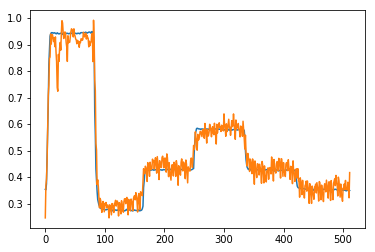

In [21]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[-0.02426301 -0.16861714 -0.15639853 -0.29681793 -0.23620182]
 [ 0.05883998 -0.07440504 -0.11996204 -0.03803963 -0.05122145]
 [-0.29822594 -0.36458358 -0.45016757 -0.33242568 -0.38511965]
 [ 0.03100713 -0.09430614 -0.05594835 -0.09966731 -0.01717615]
 [ 0.25140506 -0.17080668 -0.12288374 -0.08282083 -0.09436601]]
MSE = 380.8470764160156


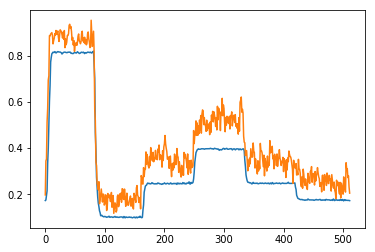

In [22]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [23]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")
    if i > 10:
        break

Target = 0, MSE = 57.594
Target = 0, MSE = 380.847
Target = 0, MSE = 2.784
Target = 0, MSE = 148.876
Target = 0, MSE = 2.825
Target = 0, MSE = 546.635
Target = 0, MSE = 2.757
Target = 0, MSE = 4.606
Target = 0, MSE = 4.895
Target = 0, MSE = 472.903
Target = 0, MSE = 4.268
Target = 0, MSE = 69.183


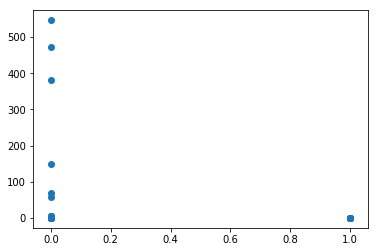

In [24]:
plt.scatter(targets, err)

Show the data plots.

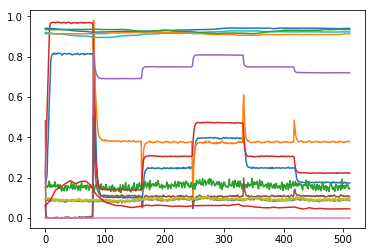

In [25]:
show_plot(sample)

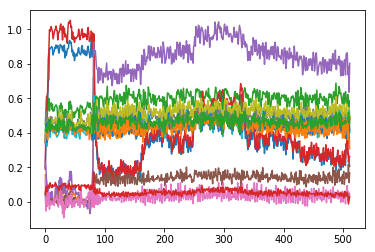

In [26]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [27]:
scores = score(test_dl, model, criterion)

100%|██████████| 1881/1881 [00:12<00:00, 148.17it/s]


In [28]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
               fail        norm
loss   4.919443e+08  145.987328
KL     4.919441e+08   56.826705
error  1.820694e+02   89.160623


In [29]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl, model, criterion).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

###################### VAL MEANS #####################
             norm
loss   146.743239
KL      55.717436
error   91.025804


In [30]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl, model, criterion).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### TRAIN MEANS #####################")
print(train_means)

100%|██████████| 9/9 [00:01<00:00,  5.80it/s]

###################### TRAIN MEANS #####################
             norm
loss   132.753411
KL      56.691490
error   76.061921


Let's calculate AUC to judge performance.

In [31]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [32]:
print(len(scores[('error', 'norm')]), len(scores[('error', 'fail')]))

108 1773


In [76]:
# simple definition of the threshold as mean between sets
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
print('mean threshold:', threshold)
# maximum 95% percentile of normal as threshold
# threshold = np.percentile(scores['error', 'norm'], 95)
# print('95th percentile threshold:', threshold)

mean threshold: 135.61500833180307


In [77]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = (t_scores[('error', 'fail')] > threshold)
t_scores[('error', 'norm')] = (t_scores[('error', 'norm')] > threshold)

t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])
t_score = np.array(t_score)

y_true = []
y_true.extend([True] * len(t_scores[('error', 'fail')]))
y_true.extend([False] * len(t_scores[('error', 'norm')]))
y_true = np.array(y_true)

In [78]:
t_corr = t_score == y_true
t_corr.sum() / len(t_corr)

0.4619883040935672

In [79]:
f1_score(y_true, t_score)

0.6092664092664093

In [80]:
auc_scores = auc_score(test_dl, t_scores)
auc_scores

0.5928746004888137

In [38]:
np.mean(scores['error', 'norm'])

89.16062303163388

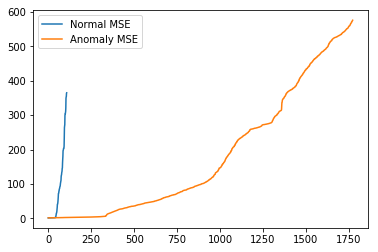

In [39]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(normaly, label='Normal MSE')
plt.plot(anomaly, label='Anomaly MSE')
plt.legend()

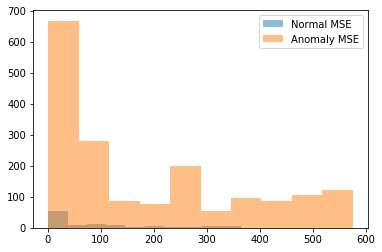

In [40]:
plt.hist(normaly, label='Normal MSE', alpha=0.5)
plt.hist(anomaly, label='Anomaly MSE', alpha=0.5)
plt.legend()

In [41]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

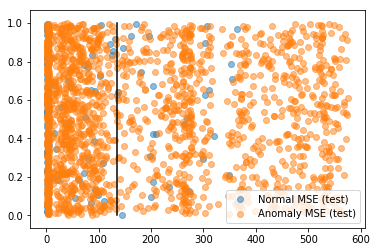

In [42]:
plt.scatter(normaly, normalx, label='Normal MSE (test)', alpha=0.5)
plt.scatter(anomaly, anomalx, label='Anomaly MSE (test)', alpha=0.5)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.legend()

Try fitting a normal distribution to the validation MSE to define a threshold.

In [43]:
val_scores = score(val_dl, model, criterion)

100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


In [44]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[1.4882421493530273, 1.530557632446289, 1.5916849374771118, 1.5954327583312988, 1.6085656881332397]
mean=91.03, stdev=113.34


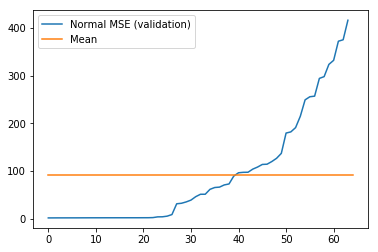

In [45]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal MSE (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [46]:
latents, targets = compute_latent(test_dl, model)

100%|██████████| 1881/1881 [00:12<00:00, 150.82it/s]


In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(n_components=2)

In [49]:
lat_pca = pca.fit_transform(latents)

In [50]:
lat_pca.shape

(1881, 2)

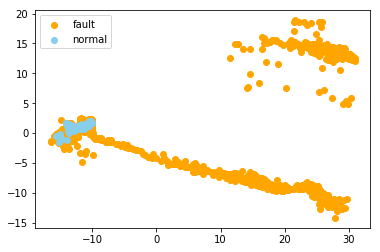

In [51]:
fail_mask = targets == 0
norm_mask = targets == 1
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [52]:
pca.explained_variance_ratio_

array([0.73571414, 0.12134892], dtype=float32)

Cluster the latent space into kmeans clusters.

In [53]:
from sklearn.cluster import KMeans

In [54]:
kmeans = KMeans(3)

In [55]:
lat_k = kmeans.fit_transform(latents)

In [56]:
lat_k.shape

(1881, 3)

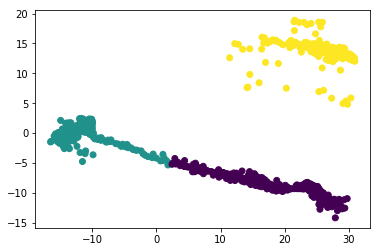

In [57]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

Try adding the error terms to the latent features.

In [58]:
latents, kl, error, targets = compute_latent_and_loss(test_dl, model, criterion)

100%|██████████| 1881/1881 [00:12<00:00, 148.38it/s]


In [59]:
print(latents.shape, kl.shape, error.shape, targets.shape)

(1881, 50) (1881,) (1881,) (1881,)


In [60]:
features = np.hstack([latents, kl[:, None], error[:, None]])
features.shape

(1881, 52)

In [61]:
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(features)
lat_pca.shape

(1881, 2)

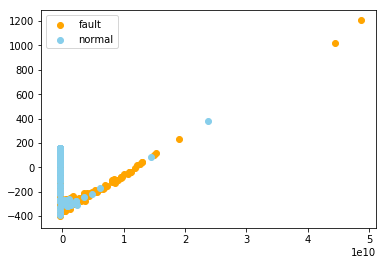

In [62]:
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [63]:
pca.explained_variance_ratio_

array([1.00000000e+00, 5.02283261e-15])

Compare the pca plots for validation and training sets.

100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


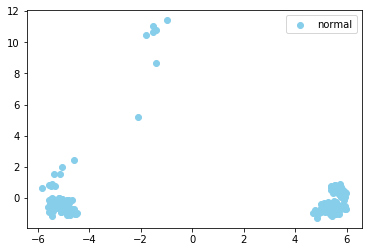

In [64]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


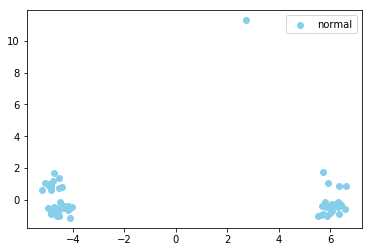

In [65]:
latents, targets = compute_latent(val_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

Combine the validation plot with the test plot to understand global structure.

In [66]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


In [67]:
latents, targets = compute_latent(val_dl, model)
val_pca = pca.transform(latents)

100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


In [68]:
latents, targets = compute_latent(test_dl, model)
test_pca = pca.transform(latents)
fail_mask = targets == 0
norm_mask = targets == 1

100%|██████████| 1881/1881 [00:12<00:00, 150.68it/s]


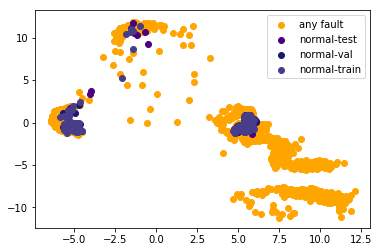

In [69]:
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.legend()

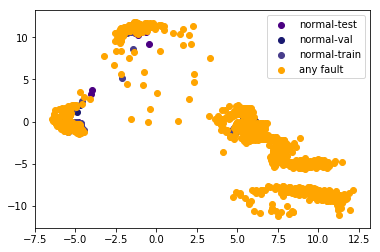

In [70]:
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.legend()